# Quadrotor Example



In [1]:
# Initialization



# Including the initializing script
include("quadrotor_script.jl")

# Number of time-discretization points and maximum number of GuSTO iterations
N, max_it = 30, 100

# Defining the model, the initial strategy and each convex subproblem
model      = Quadrotor()
Xp,Up      = initialize_trajectory(model,N)
SCPproblem = GuSTOProblem(model,N,Xp,Up)

# Defining GuSTO parameters
Delta0, omega0, omegamax, epsilon, rho0,
rho1, beta_succ, beta_fail, gamma_fail, convergence_threshold = get_initial_gusto_parameters(model)

(100.0, 1.0, 1.0e9, 0.001, 10.0, 20.0, 2.0, 0.5, 5.0, 5.0)

In [2]:
# GuSTO Algorithm



# Defining penalization weights, trust-region radius and the list of solutions
Xp,Up        = initialize_trajectory(model,N)
X, U         = copy(Xp), copy(Up)
omega, Delta = omega0, Delta0
X_all, U_all = [], []
push!(X_all, copy(X))
push!(U_all, copy(U))

# GuSTO loop
success, it = false, 1
while it < max_it                                                               && 
      !(success && convergence_metric(model,X,U,Xp,Up) < convergence_threshold) &&
      omega < omegamax
    
    println("-----------")
    println("Iteration $it")
    println("-----------")
    
    # Storing the solution at the previous step and the linearized dynamics
    Xp                        = copy(X)
    Up                        = copy(U)
    model.f, model.A, model.B = compute_dynamics(model,Xp,Up)
    
    # Defining the convex subproblem
    reset_problem(SCPproblem,model)
    set_parameters(SCPproblem,model,Xp,Up,omega,Delta)
    define_cost(SCPproblem,model)
    define_constraints(SCPproblem,model)
    
    # Solving the convex subproblem
    JuMP.optimize!(SCPproblem.solver_model)
    X_sol = JuMP.value.(SCPproblem.X)
    U_sol = JuMP.value.(SCPproblem.U)
    
    # GuSTO Logic
    
    # Trust-region constraints are satisfied
    if is_in_trust_region(model,X_sol,U_sol,Xp,Up,Delta)
        
        # Computing accuracy ratio rho
        rho = accuracy_ratio(SCPproblem,model,X_sol,U_sol,Xp,Up)

        # Too coarse linearization: reject solution
        if rho > rho1
            println("Reject solution (the linearization is too coarse).")
            Delta   = beta_fail*Delta
            omega   = omega
            success = false
        
        # Accepting solution
        else
            println("Accept solution.")
            X       = copy(X_sol)
            U       = copy(U_sol)
            success = true
            
            # Optimal linearization precision
            if rho < rho0
                Delta = min(beta_succ*Delta,Delta0)
                
            # Suboptimal linearization precision
            else
                Delta = Delta
            end
            
            # Hard satisfaction of state constraints
            if satisfies_state_inequality_constraints(SCPproblem,model,X_sol,U_sol,Xp,Up,Delta)
                omega = omega0
                
            # State constraints are not satisfied: increase penalization weights
            else
                println("Solution does not satisfy state constraints, increasing omega.")
                omega   = gamma_fail*omega
                success = false
            end
        end
        
    # Trust-region constraints are NOT satisfied
    else
        println("Reject solution (the trust region constraints are not satisfied).")
        Delta   = Delta
        omega   = gamma_fail*omega
        success = false
    end

    # Collecting the solution at each iteration
    push!(X_all,copy(X))
    push!(U_all,copy(U))
    it += 1
    
    println("Parameters:")
    println("omega  = $omega")
    println("delta  = $Delta")
    println("metric = $(convergence_metric(model,X,U,Xp,Up))")
    println(" ")
end


-----------
Iteration 1
-----------

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Accept solution.
Solution does not satisfy state constraints, increasing omega.
Parameters:
omega  = 5.0
delta  = 100.0
metric = 73.04677388963574
 
-----------
Iteration 2
-----------
Accept solution.
Parameters:
omega  = 1.0
delta  = 100.0
metric = 24.487479780901
 
-----------
Iteration 3
-----------
Accept solution.
Parameters:
omega  = 1.0
delta  = 100.0
metric = 10.016419450937514
 
-----------
Iteration 4
-----------
Accept solution.
Parameters:
omega  = 1.0
delta  = 100.0
metric = 2.4031183208645057
 


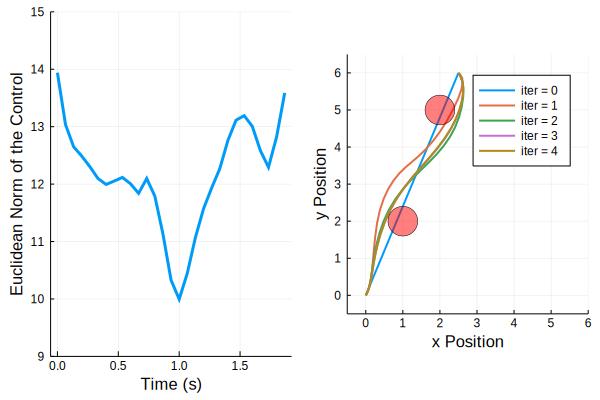

In [3]:
# Plotting the solution



# Collecting the final control
timeSpan = zeros(N-1)
normU = zeros(N-1)
normU[1] = sqrt(U_all[end][1,1]^2 + U_all[end][2,1]^2 + U_all[end][3,1]^2)
for i = 1:N-2
    
    # Collecting times
    timeSpan[i+1] = timeSpan[i] + 2.0/N
    
    # Collecting the norm of the control u
    normU[i+1] = sqrt(U_all[end][1,i+1]^2 + U_all[end][2,i+1]^2 + U_all[end][3,i+1]^2)
end

# Plotting the final control
p1 = plot(timeSpan,normU,ylims=(9,15),linewidth=3,label="",xlabel="Time (s)",ylabel="Euclidean Norm of the Control")

# Plotting the trajectory at different SCP iterations
p2 = plot_solutions(SCPproblem, model, X_all[1:end], U_all[1:end])

plot(p1,p2,layout=(1,2))